# Single-cell RNA sequencing data analysis tutorial

In this session, you will process another dataset of dataset of peripheral blood mononuclear cells (PBMCs), ultimately run into an issue, and get the chance to brainstorm about possible solutions to resolve the problem.

Useful links:
* [anndata](https://anndata.readthedocs.io/en/stable/)
* [scanpy](https://scanpy.readthedocs.io/en/stable/)
* [Single-cell best practices book](https://www.sc-best-practices.org/preamble.html)

## Library imports

In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import anndata as ad
import scanpy as sc

# `DATA_DIR` is a pathlib Path pointing to this repo's data directory.
# You can specify a path with the syntax `DATA_DIR / path / to / file`.
from crabs import DATA_DIR

## General settings

In [2]:
# Set the verbosity of Scanpy to 2
sc.settings.verbosity = 2

## Constants

## Function definitions

## Data loading

In [ ]:
# Load the data of the first dataset b1 into the AnnData format
b1_counts = pd.read_csv(DATA_DIR / "pbmc" / "raw" / "b1_exprs.txt.gz", sep="\t", index_col=0)
b1_metadata = pd.read_csv(DATA_DIR / "pbmc" / "raw" / "b1_celltype.txt.gz", index_col=0, sep="\t")

adata_1 = ad.AnnData(b1_counts.T)
adata_1.obs = b1_metadata.loc[adata_1.obs_names, :]
adata_1

In [ ]:
# Load the data of the second dataset b2 into the AnnData format
b2_counts = pd.read_csv(DATA_DIR / "pbmc" / "raw" / "b2_exprs.txt.gz", sep="\t", index_col=0)
b2_metadata = pd.read_csv(DATA_DIR / "pbmc" / "raw" / "b2_celltype.txt.gz", index_col=0, sep="\t")

adata_2 = ad.AnnData(b2_counts.T)
adata_2.obs = b2_metadata.loc[adata_2.obs_names, :]
adata_2

## Data exploration

In [6]:
adata_1

AnnData object with n_obs × n_vars = 8098 × 33694
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType'

In [9]:
adata_1.obs["Sample"].unique()

array(['data_3p'], dtype=object)

In [5]:
# Convert the count data into an appropriate, data-efficient format
adata_1.X = csr_matrix(adata_1.X)
adata_2.X = csr_matrix(adata_2.X)

In [11]:
# Does the cell metadata include information to uniquely identify each dataset?
# If so, rename it to `"sample"`; if not, add the dataset-specific identifiers `"sample_1"` and `"sample_2"` as
# the column `"sample"` to each AnnData's cell metadata (.obs).
adata_1.obs = adata_1.obs.rename(columns={"Sample": "sample"})
adata_2.obs = adata_2.obs.rename(columns={"Sample": "sample"})

In [15]:
# Combine the two AnnData objetcs into a single one
adata = ad.concat(adatas=[adata_1, adata_2])

# Convert column names to consistent, snake case format
adata.obs.columns = adata.obs.columns.str.replace("(?<=[a-z])(?=[A-Z])", "_", regex=True).str.lower()

adata

AnnData object with n_obs × n_vars = 15476 × 33694
    obs: 'sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'method', 'cell_type'

In [16]:
# Delete the individual data objects to reduce the memory footprint
del adata_1
del adata_2

## Quality control

In [17]:
# Remove cells with less than 100 transcripts
sc.pp.filter_cells(adata, min_counts=100)
adata

AnnData object with n_obs × n_vars = 15476 × 33694
    obs: 'sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'method', 'cell_type'

In [18]:
# Remove genes expressed in less than 10 cells
sc.pp.filter_genes(adata, min_cells=10)
adata

filtered out 16264 genes that are detected in less than 10 cells


AnnData object with n_obs × n_vars = 15476 × 17430
    obs: 'sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'method', 'cell_type'
    var: 'n_cells'

In [19]:
# Detect mitochondrial genes and add a boolean flag to the gene metadata
adata.var["mt"] = adata.var_names.str.upper().str.startswith(("MT-", "MT"))

In [20]:
# Detect ribosomal genes and add a boolean flag to the gene metadata
adata.var["ribo"] = adata.var_names.str.upper().str.startswith(("RPS", "RPL"))

In [21]:
# Compute cell-wise quality metrics
# - Total counts
# - The number of genes expressed each cell
# - Total number of counts for mitochondrial genes
# - Proportion of total counts which are mitochondrial
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo"], percent_top=[20], log1p=True, inplace=True)

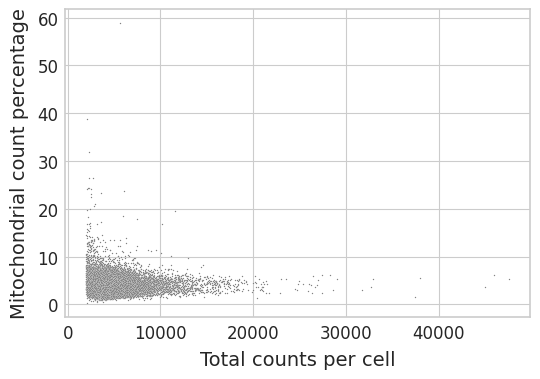

In [22]:
# Plot the number of transcripts present in each cell against the percentage of observed mitochondrial genes
with mplscience.style_context():
    sns.set_style(style="whitegrid")

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.scatterplot(data=adata.obs, x="total_counts", y="pct_counts_mt", s=1, color="grey", ax=ax)
    ax.set(xlabel="Total counts per cell", ylabel="Mitochondrial count percentage")

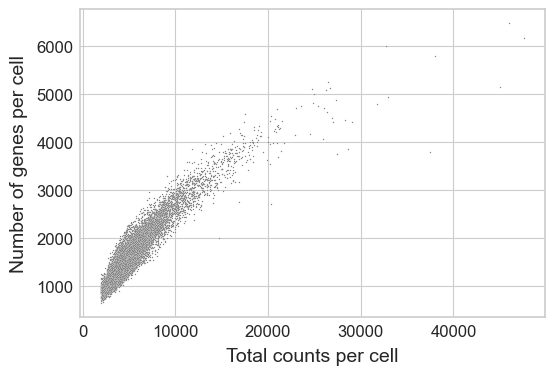

In [23]:
# Plot the number of transcripts present in each cell against the number of genes
with mplscience.style_context():
    sns.set_style(style="whitegrid")

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.scatterplot(data=adata.obs, x="total_counts", y="n_genes_by_counts", s=1, color="grey", ax=ax)
    ax.set(xlabel="Total counts per cell", ylabel="Number of genes per cell")
    plt.show()

In [24]:
# Remove likely dead/dying cells and data outliers
outlier_obs_mask = (adata.obs["total_counts"] > 20000).values | (adata.obs["pct_counts_mt"] > 20).values

adata = adata[~outlier_obs_mask, :].copy()
adata

AnnData object with n_obs × n_vars = 15409 × 17430
    obs: 'sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'method', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

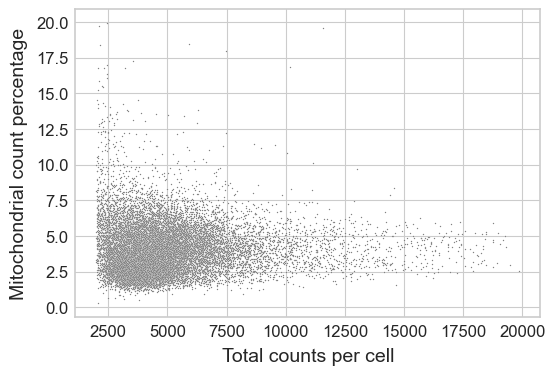

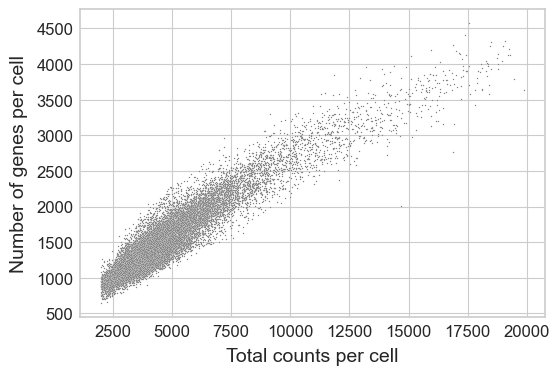

In [25]:
# Replot above's plots
with mplscience.style_context():
    sns.set_style(style="whitegrid")

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.scatterplot(data=adata.obs, x="total_counts", y="pct_counts_mt", s=1, color="grey", ax=ax)
    ax.set(xlabel="Total counts per cell", ylabel="Mitochondrial count percentage")

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.scatterplot(data=adata.obs, x="total_counts", y="n_genes_by_counts", s=1, color="grey", ax=ax)
    ax.set(xlabel="Total counts per cell", ylabel="Number of genes per cell")
    plt.show()

## Data preprocessing

### Transformation and feature selection

In [26]:
# Normalize the cells to their median library size (total number of transcripts per cell)
sc.pp.normalize_total(adata)

normalizing counts per cell
    finished (0:00:00)


In [27]:
# Log1p transform the data
sc.pp.log1p(adata)

In [28]:
# Select highly variable genes
sc.pp.highly_variable_genes(adata, subset=False)

extracting highly variable genes
    finished (0:00:00)


### Dimensionality reduction

In [29]:
# Compute the principal component embedding
sc.tl.pca(adata)

computing PCA
    with n_comps=50
    finished (0:00:00)


/Users/philipp/miniforge3/envs/crabs-py311/lib/python3.11/site-packages/sklearn/utils/sparsefuncs.py:737: RuntimeWarning: divide by zero encountered in matmul
  matmat=lambda x: X @ x - offset @ x,
/Users/philipp/miniforge3/envs/crabs-py311/lib/python3.11/site-packages/sklearn/utils/sparsefuncs.py:737: RuntimeWarning: overflow encountered in matmul
  matmat=lambda x: X @ x - offset @ x,
/Users/philipp/miniforge3/envs/crabs-py311/lib/python3.11/site-packages/sklearn/utils/sparsefuncs.py:737: RuntimeWarning: invalid value encountered in matmul
  matmat=lambda x: X @ x - offset @ x,


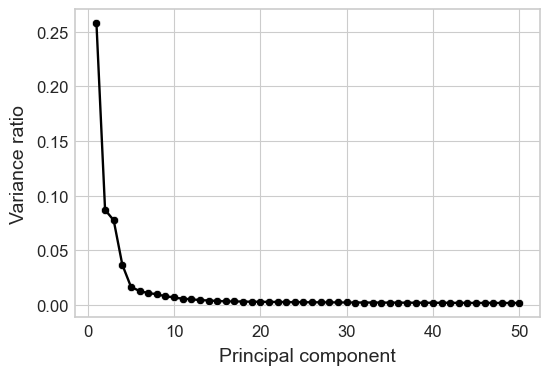

In [30]:
# What is a suitbale number of principle components to use

n_pcs = len(adata.uns["pca"]["variance_ratio"])
with mplscience.style_context():
    sns.set_style("whitegrid")

    df = pd.DataFrame({"variance_ratio": adata.uns["pca"]["variance_ratio"], "pc": np.arange(start=1, stop=n_pcs + 1)})

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.lineplot(data=df, x="pc", y="variance_ratio", color="black", ax=ax)
    sns.scatterplot(data=df, x="pc", y="variance_ratio", color="black", ax=ax)
    ax.set(xlabel="Principal component", ylabel="Variance ratio")

    plt.show()

In [31]:
# Compute a k-nearest neighbor graph with k=30
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:09)


computing UMAP
    finished (0:00:05)


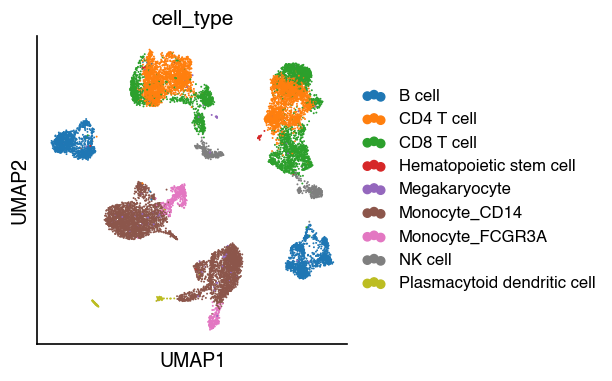

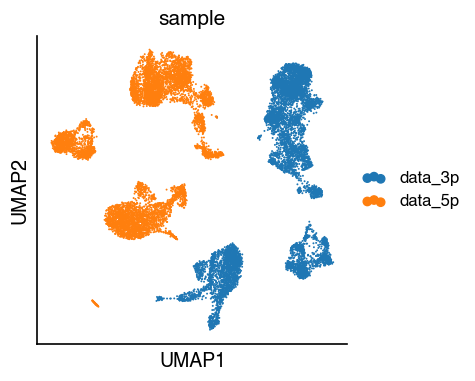

In [34]:
# Compute and plot the UMAP embedding of the data, colored by cell type and sample
# What do you observe?
sc.tl.umap(adata)

with mplscience.style_context():
    sc.pl.umap(adata, color="cell_type")
    sc.pl.umap(adata, color="sample")
    plt.show()